In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import csv
# from playML.LDA import LDA
from playML.metrics import plot_decision_boundary
from playML.Bayers import BayersGN
X_train, y_train = np.loadtxt("X.csv", delimiter=","),np.loadtxt("y.csv", delimiter=",")
X_test, y_test =  np.loadtxt("X_test.csv", delimiter=","), np.loadtxt("y_test.csv", delimiter=",")

In [3]:
from numpy.linalg import inv
def accuracy_score(y_true, y_predict):
    """y_true and y_predict """
    assert y_true.shape[0] == y_predict.shape[0], \
        "the size of y_true must be equal to the size of y_predict"
    return sum(y_predict == y_true) / len(y_true)

class LDA:
    def __init__(self, priors =[0.5,0.5]):
        """init the LDA model"""
        """between-class scatter matrix"""
        self._Sb = None
        """pooled within-class scatter matrix"""
        self._Sw = None
        """各类的均值"""
        self._mean = None
        """各类的离散度矩阵    样本协防差"""
        self._cov = None
        """权向量"""
        self._w = None
        """w0"""
        self._w0 = None
        """先验概率"""
        self._priors = priors

    def fit(self, X_train, y_train):
        X_train, y_train = np.array(X_train), np.array(y_train)
        sorted_y = np.sort(np.unique(y_train))
        self._mean = np.array([X_train[y_train == y].mean(axis=0) for y in sorted_y])
        self._cov = np.array([np.cov(X_train[y_train == y].T) for y in sorted_y])
        self._Sw = sum(self._cov)
        mean_minus = np.array(self._mean[0] - self._mean[1])
        mean_add = np.array(self._mean[0] + self._mean[1])
        self._Sb = np.matmul(mean_minus, mean_minus.T)
        inv_Sw = inv(self._Sw)
        self._w = np.matmul(inv_Sw, mean_minus)
        self._w0 = -1/2 * np.matmul(mean_add.T, self._w) - np.log(self._priors[0]/self._priors[1])
        return self

    def predict(self, X_test):
        return np.array([self._predict(x) for x in X_test])

    def _predict(self, X_test):
        return np.array([self._g(X_test)<0], dtype="float64")

    def _g(self, X_test):
        return np.matmul(self._w.T, X_test) + self._w0

    def decision_function(self, X_test):
        b = [self._g(X_test[i]) for i in range(len(X_test))]
        return b

    def score(self, X_test, y_test):
        """根据数据集X_test，y_test计算准确度 分类准确度使用accuracy_score"""
        y_predict = self.predict(X_test)
        return accuracy_score(y_test, y_predict.reshape(-1))


In [4]:
priors = [0.25, 0.75]

In [88]:
priors = [0.25, 0.75]
models = [
            LDA(priors = priors),
            BayersGN(priors=priors)
         ]
models = [clf.fit(X_train[:,:2], y_train) for clf in models]
scores = np.array([model.score(X_test[:,:2], y_test) for model in models])
scores

array([0.81395349, 0.88372093])

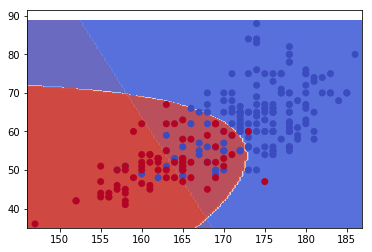

In [90]:
fig, sub = plt.subplots(1, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
[plot_decision_boundary(sub, model=clf,X= X_train[:,:2],h=0.3) for clf in models]
sub.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.coolwarm)

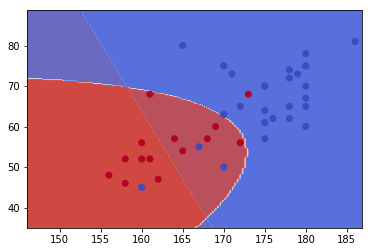

In [54]:
fig, sub = plt.subplots(1, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
[plot_decision_boundary(sub, model=clf,X= X_train[:,:2],h=0.3) for clf in models]
sub.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=plt.cm.coolwarm)

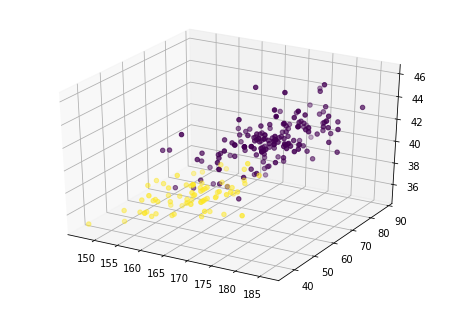

In [78]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_train[:,0],X_train[:,1],X_train[:,2],c=y_train)

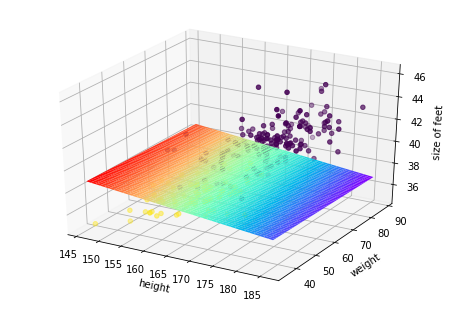

In [99]:
clf_3d =LDA(priors=[0.1,0.9])
clf_3d.fit(X_train, y_train)
labels = ["height","weight", "size of feet"]
plot_con_surface(clf_3d, X_train,y_train,labels, h=1)
plt.show()

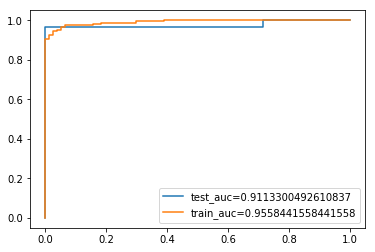

In [86]:
clf_3d =LDA(priors=[0.25,0.75])
clf_3d.fit(X_train, y_train)
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
dec = clf_3d.decision_function(X_test)
pred = clf_3d.predict(X_test)
f, t, _ = roc_curve(y_test, dec)
auc = roc_auc_score(y_test,pred)

plt.plot(t, f,label="test_auc="+str(auc))
dec = clf_3d.decision_function(X_train)
f, t, _ = roc_curve(y_train, dec)
pred = clf_3d.predict(X_train)
auc = roc_auc_score(y_train,pred)
plt.plot(t, f,label="train_auc="+str(auc))
plt.legend()
plt.show()

In [64]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
one = loo.split(X_train[:,:2])
score=0
for train, test in one:
    clf.fit(X_train[train,:2], y_train[train])
    score+=clf.score(X_train[test,:2], y_train[test])
score/len(X_train)

0.8305785123966942

In [66]:
def LeaveOneOut(X, y, clf):
    """留一法"""
    score = 0
    for i in range(len(X)):
        index = np.ones(len(X), dtype=np.bool)
        index[i] = False
        clf.fit(X[index], y[index])
        score += clf.score(X[i].reshape(1,-1), y[i].reshape(1,-1))

    return score / len(X)

In [62]:
clf = LDA(priors = priors)
# from playML.metrics import LeaveOneOut
score = LeaveOneOut(X_train[:,:2], y_train, clf)
score

array([0.83057851])

In [69]:
%%time
clf = LDA(priors = priors)
# from playML.metrics import LeaveOneOut
score = LeaveOneOut(X_train, y_train, clf)
print(score)

[0.95867769]
CPU times: user 210 ms, sys: 0 ns, total: 210 ms
Wall time: 206 ms


In [70]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9302325581395349